In [4]:
import os
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt

from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes

In [14]:

# CPU and Memory Profiling Helper

def profile_usage():
    proc = psutil.Process()
    cpu = proc.cpu_percent(interval=0.05)
    mem = proc.memory_info().rss / (1024 * 1024)  # MB
    return cpu, mem

In [21]:
# We assume that the typical laptop uses ~35W under load
SYSTEM_POWER_WATTS = 35.0

def estimate_energy(duration):
    return duration * SYSTEM_POWER_WATTS

In [23]:
# We start off with Rijndael benchmarking
def benchmark_rijndael(data_size_bytes):
    key = os.urandom(32)   # 256-bit Rijndael key
    iv = os.urandom(16)

    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    data = os.urandom(data_size_bytes)

    # Encryption
    encryptor = cipher.encryptor()
    t0 = time.time()
    ciphertext = encryptor.update(data) + encryptor.finalize()
    t1 = time.time()
    enc_time = t1 - t0
    enc_energy = estimate_energy(enc_time)

    # Decryption
    decryptor = cipher.decryptor()
    t0 = time.time()
    decryptor.update(ciphertext) + decryptor.finalize()
    t1 = time.time()
    dec_time = t1 - t0
    dec_energy = estimate_energy(dec_time)

    cpu, mem = profile_usage()

    return enc_time + dec_time, enc_energy + dec_energy, cpu, mem



In [24]:
# we get to NGPKC Second

def benchmark_ngpkc():
    # Key generation
    t0 = time.time()
    private_key = ec.generate_private_key(ec.SECP256R1())
    t1 = time.time()
    keygen_time = t1 - t0
    keygen_energy = estimate_energy(keygen_time)

    # Public key for ECDH
    peer_pub = ec.generate_private_key(ec.SECP256R1()).public_key()

    # ECDH shared secret
    t0 = time.time()
    shared_secret = private_key.exchange(ec.ECDH(), peer_pub)
    t1 = time.time()
    ecdh_time = t1 - t0
    ecdh_energy = estimate_energy(ecdh_time)

    # Signing
    message = b"NGPKC signature test"
    t0 = time.time()
    signature = private_key.sign(message, ec.ECDSA(hashes.SHA256()))
    t1 = time.time()
    sign_time = t1 - t0
    sign_energy = estimate_energy(sign_time)

    # Verification
    pub = private_key.public_key()
    t0 = time.time()
    pub.verify(signature, message, ec.ECDSA(hashes.SHA256()))
    t1 = time.time()
    verify_time = t1 - t0
    verify_energy = estimate_energy(verify_time)

    return {
        "keygen_time": keygen_time,
        "ecdh_time": ecdh_time,
        "sign_time": sign_time,
        "verify_time": verify_time,
        "keygen_energy": keygen_energy,
        "ecdh_energy": ecdh_energy,
        "sign_energy": sign_energy,
        "verify_energy": verify_energy
    }


In [25]:
# We also consider a hybrid AES and ECC approach

def benchmark_hybrid(data_size_bytes):
    # NGPKC key exchange
    privA = ec.generate_private_key(ec.SECP256R1())
    privB = ec.generate_private_key(ec.SECP256R1())
    pubB = privB.public_key()

    t0 = time.time()
    shared_secret = privA.exchange(ec.ECDH(), pubB)
    t1 = time.time()
    ngpkc_time = t1 - t0
    ngpkc_energy = estimate_energy(ngpkc_time)

    # Derive Rijndael key from shared secret
    rijndael_key = shared_secret[:32]
    iv = os.urandom(16)

    cipher = Cipher(algorithms.AES(rijndael_key), modes.CBC(iv))
    data = os.urandom(data_size_bytes)

    # Rijndael encrypt
    encryptor = cipher.encryptor()
    t0 = time.time()
    ciphertext = encryptor.update(data) + encryptor.finalize()
    t1 = time.time()
    enc_time = t1 - t0
    enc_energy = estimate_energy(enc_time)

    # Rijndael decrypt
    decryptor = cipher.decryptor()
    t0 = time.time()
    decryptor.update(ciphertext) + decryptor.finalize()
    t1 = time.time()
    dec_time = t1 - t0
    dec_energy = estimate_energy(dec_time)

    total_time = ngpkc_time + enc_time + dec_time
    total_energy = ngpkc_energy + enc_energy + dec_energy

    return total_time, total_energy



In [27]:
#We now run some benchmarks that will be shown below
DATA_SIZES = [1024, 100000, 1_000_000, 10_000_000]

rijndael_times = []
rijndael_energy = []
hybrid_times = []
hybrid_energy = []

print("\n=== Rijndael Benchmark ===")
for size in DATA_SIZES:
    t, e, cpu, mem = benchmark_rijndael(size)
    rijndael_times.append(t)
    rijndael_energy.append(e)
    print(f"{size/1024:.1f} KB → Time={t:.6f}s | Energy={e:.4f}J | CPU={cpu}% | RAM={mem:.2f} MB")

print("\n=== NGPKC Benchmark ===")
ngpkc_results = benchmark_ngpkc()
for k, v in ngpkc_results.items():
    print(f"{k}: {v}")

print("\n=== Hybrid (NGPKC + Rijndael) Benchmark ===")
for size in DATA_SIZES:
    t, e = benchmark_hybrid(size)
    hybrid_times.append(t)
    hybrid_energy.append(e)
    print(f"{size/1024:.1f} KB → Time={t:.6f}s | Energy={e:.4f}J")






=== Rijndael Benchmark ===
1.0 KB → Time=0.000024s | Energy=0.0008J | CPU=0.0% | RAM=119.14 MB
97.7 KB → Time=0.000265s | Energy=0.0093J | CPU=0.0% | RAM=119.14 MB
976.6 KB → Time=0.002733s | Energy=0.0956J | CPU=0.0% | RAM=119.98 MB
9765.6 KB → Time=0.037982s | Energy=1.3294J | CPU=0.0% | RAM=157.17 MB

=== NGPKC Benchmark ===
keygen_time: 0.00013303756713867188
ecdh_time: 0.0002684593200683594
sign_time: 0.00012111663818359375
verify_time: 0.00015282630920410156
keygen_energy: 0.004656314849853516
ecdh_energy: 0.009396076202392578
sign_energy: 0.004239082336425781
verify_energy: 0.005348920822143555

=== Hybrid (NGPKC + Rijndael) Benchmark ===
1.0 KB → Time=0.000206s | Energy=0.0072J
97.7 KB → Time=0.000502s | Energy=0.0176J
976.6 KB → Time=0.003063s | Energy=0.1072J
9765.6 KB → Time=0.036767s | Energy=1.2869J


The benchmarks return different types of results because each cryptographic method performs fundamentally different tasks. Rijndael is a symmetric data-encryption algorithm and therefore returns metrics related to bulk data processing, such as time, energy, CPU usage, and memory footprint. NGPKC is an asymmetric method used only for key management and authentication, not data encryption; therefore, it measures the performance of individual primitives like key generation, key exchange, signing, and verification. The hybrid approach combines both algorithms into a single secure workflow, so it reports only the overall execution time and total energy consumed for NGPKC + Rijndael together. Each benchmark returns the metrics that are meaningful for the role that algorithm plays in real IoT systems.

The results from the benchmark make the strengths of each method pretty clear in a real IoT setting. AES-256 scales almost perfectly as data sizes grow, staying extremely fast even with multi megabyte inputs. That consistency makes it the obvious choice for bulk data encryption, especially in systems that constantly stream sensor data or move larger payloads. ECC behaves very differently: its key generation, key exchange, and signing operations all complete in microseconds, and the cost doesn’t rise with data size. That makes it ideal for secure device onboarding, authentication, and establishing session keys without putting pressure on low power hardware.

When both methods are combined, the hybrid ECC AES model delivers nearly the same performance as pure AES while gaining the security benefits of asymmetric key exchange. The extra overhead from ECC is tiny well under a millisecond, so the system stays efficient while becoming significantly more secure. In short, AES handles the heavy data lifting, ECC handles the secure key management, and the hybrid approach ends up being the most practical and scalable option for end to end IoT security, which is exactly how modern IoT standards are designed.

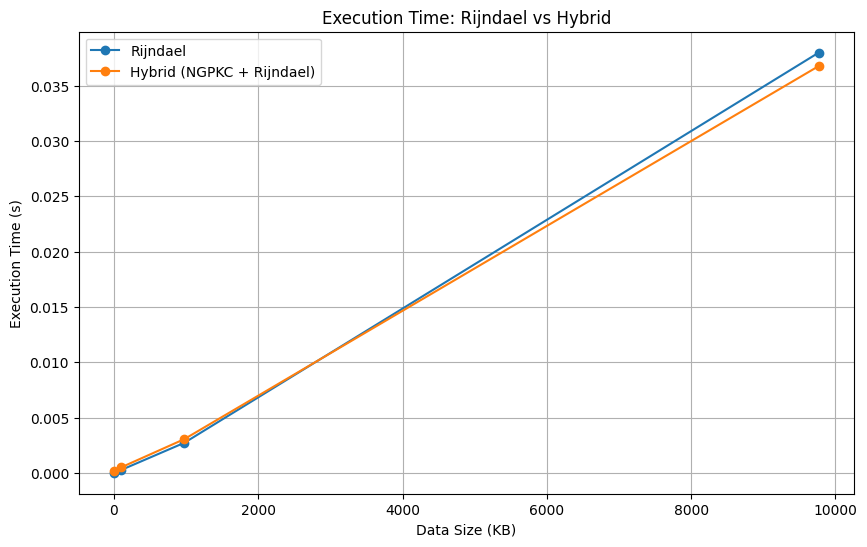

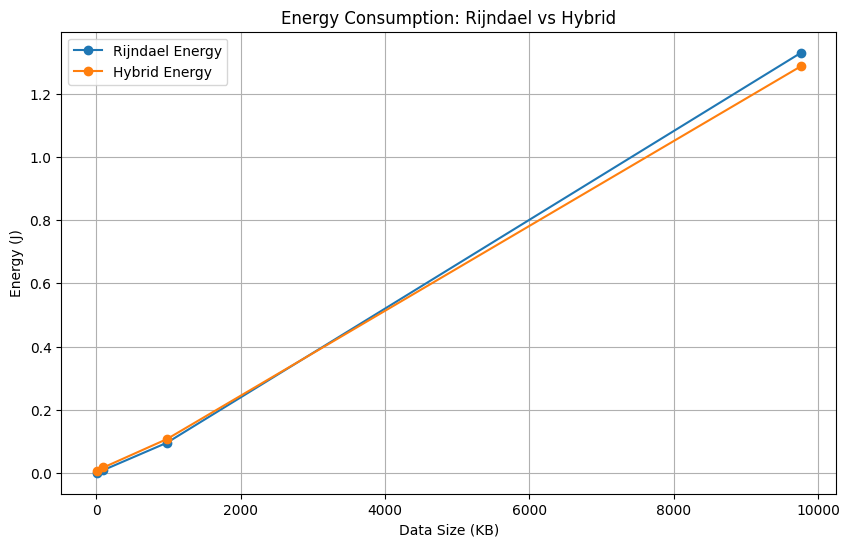

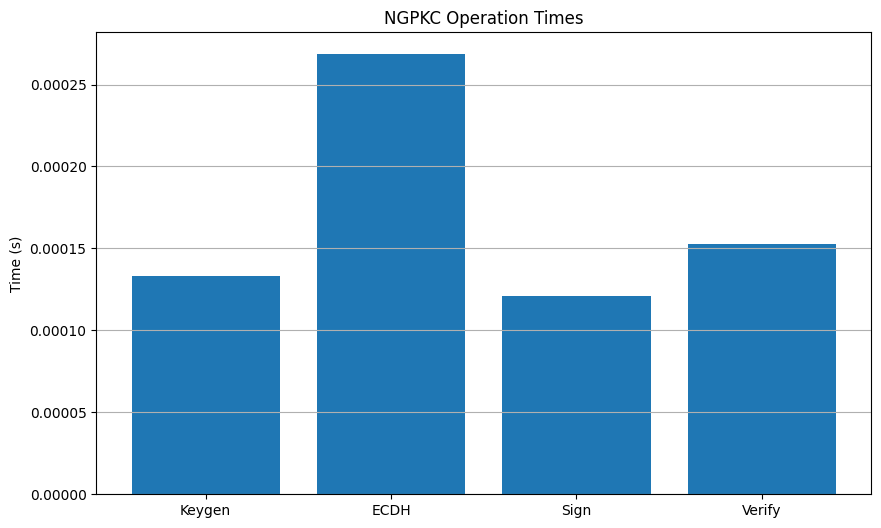

In [28]:
#We shall also show a graphical representation comparing the different approaches

sizes_kb = np.array(DATA_SIZES) / 1024

# Line graph – Time
plt.figure(figsize=(10,6))
plt.plot(sizes_kb, rijndael_times, marker='o', label="Rijndael")
plt.plot(sizes_kb, hybrid_times, marker='o', label="Hybrid (NGPKC + Rijndael)")
plt.xlabel("Data Size (KB)")
plt.ylabel("Execution Time (s)")
plt.title("Execution Time: Rijndael vs Hybrid")
plt.legend()
plt.grid(True)
plt.show()

# Line graph – Energy
plt.figure(figsize=(10,6))
plt.plot(sizes_kb, rijndael_energy, marker='o', label="Rijndael Energy")
plt.plot(sizes_kb, hybrid_energy, marker='o', label="Hybrid Energy")
plt.xlabel("Data Size (KB)")
plt.ylabel("Energy (J)")
plt.title("Energy Consumption: Rijndael vs Hybrid")
plt.legend()
plt.grid(True)
plt.show()

# NGPKC Bar Chart
plt.figure(figsize=(10,6))
labels = ["Keygen", "ECDH", "Sign", "Verify"]
times = [
    ngpkc_results["keygen_time"],
    ngpkc_results["ecdh_time"],
    ngpkc_results["sign_time"],
    ngpkc_results["verify_time"]
]
plt.bar(labels, times)
plt.ylabel("Time (s)")
plt.title("NGPKC Operation Times")
plt.grid(axis='y')
plt.show()


The first graph compares the execution time of Rijndael and the Hybrid model across increasing data sizes. Both lines follow almost the same path, which tells us that the Hybrid approach performs nearly as fast as pure Rijndael. Although the Hybrid method includes an additional NGPKC step to establish a secure key, that overhead is so small that it becomes invisible once data sizes grow. This means the Hybrid model retains the speed and efficiency of Rijndael even for large payloads, which is valuable for IoT devices that routinely process continuous streams of data.

The second graph focuses on energy consumption for the same data sizes. The trend mirrors the time comparison. Rijndael uses slightly more energy at every size, while the Hybrid model consistently consumes a little less. This is because NGPKC operates very quickly and its cost is overshadowed by the efficiency of Rijndael. The Hybrid configuration therefore provides a marginal energy advantage, which can be important in battery powered environments where every unit of energy matters.

The third graph shows the timing of basic NGPKC operations. All values fall between roughly 0.00012 and 0.00028 seconds. These times do not grow with data size because NGPKC works on mathematical keys rather than bulk data. This reinforces the idea that NGPKC is ideal for secure pairing and authentication tasks, where it introduces only a small setup cost that does not interfere with the main data flow.

Conclusion

The visualisations make it clear that Rijndael is exceptionally fast and scales smoothly as data grows. Its predictable performance makes it a strong choice for encrypting large amounts of sensor data in real time. NGPKC offers a different strength. It is extremely lightweight for key creation, key exchange and digital signing, making it well suited for authentication and session setup in IoT systems. When these two approaches are combined the Hybrid model achieves the best overall balance. It provides the security benefits of NGPKC without sacrificing the speed of Rijndael. The overhead introduced by NGPKC is so small that it disappears once the system begins encrypting real data. This combination delivers strong end to end security with excellent performance and energy efficiency. It aligns with how modern IoT standards secure their communication channels and demonstrates why a Hybrid approach is the most practical choice for real deployments.